In [1]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
from collections import deque
import glob
import imageio
# Import everything needed to edit/save/watch video clips
#imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline




In [2]:
# load pickled distortion matrix
with open('camera_cal/output/cal_dist_pickle.p', mode='rb') as f:
    dist_pickle = pickle.load(f)
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]

In [3]:
# Read in an image
#img = cv2.imread('test_image.png')

# TODO: Write a function that takes an image, object points, and image points
# performs the camera calibration, image distortion correction and 
# returns the undistorted image
def cal_undistort(img):
    # Use cv2.calibrateCamera() and cv2.undistort()
    #ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[0:2], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    #undist = np.copy(img)  # Delete this line
    return undist

In [4]:
# Convert to grayscale
def to_grayscale(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return gray

In [5]:
def abs_sobel_thresh(img, orient='x', thresh_min=85, thresh_max=195):
    # Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(img, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(img, cv2.CV_64F, 0, 1)
    # Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    sobel_binary = np.zeros_like(scaled_sobel)
    sobel_binary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    # Return this mask as your binary_output image
    #binary_output = np.copy(img) # Remove this line
    return sobel_binary

In [6]:
def rgb_thresh(img):
    # R & G thresholds so that yellow lanes are detected well.
    color_threshold = 150
    R = img[:,:,0]
    G = img[:,:,1]
    color_combined = np.zeros_like(R)
    r_g_condition = (R > color_threshold) & (G > color_threshold)
    return r_g_condition

In [7]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Take the derivative in x or y given orient = 'x' or 'y'
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    absgraddir = np.arctan2(abs_sobely, abs_sobelx)
    # Create a binary mask where direction thresholds are met # no scaling
    dir_binary =  np.zeros_like(absgraddir)
    dir_binary[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    return dir_binary

In [8]:
def hls_select(img, s_thresh=(110, 255)):
    # Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    # Apply a threshold to the S channel
    s_binary = np.zeros_like(S)
    s_binary[(S > s_thresh[0]) & (S <= s_thresh[1])] = 1
    
    # Return a binary image of threshold result
    #binary_hls[((s_binary == 1))] =1

    return s_binary

In [9]:
def mask_ROI(image):
    # apply the region of interest mask
    height,width = image.shape
    #print(image.shape,height,width)
    mask = np.zeros_like(image)
    #region_of_interest_vertices = np.array([[0,height-1], [width/2, int(0.5*height)], [width-1, height-1]], dtype=np.int32)
    region_of_interest_vertices = np.array( [[(width/7, height),(0.4*width, 0.6*height),(0.6*width, 0.6*height),(0.92*width, height)]], dtype=np.int32 )
    cv2.fillPoly(mask, [region_of_interest_vertices], 1)
    plt.imshow(mask)
    ROI_thresholded = cv2.bitwise_and(image, mask)
    return ROI_thresholded

In [10]:
def perspactive_transform(img, warp=True):
    offset = [150,0] # offset for dst points
    # Grab the image shape
    img_size = (img.shape[1], img.shape[0])
    # define 4 corners of ROI
    #corners = np.float32([[190,720],[589,470],[698,470],[1145,720]])
    corners = np.float32([[200,720],[570,470],[722,470],[1130,720]])
    # define 4 
    src = np.float32([corners[0], corners[1], corners[2], corners[3]])
    # define 4 destination points dst = np.float32([[,],[,],[,],[,]])
    dst = np.float32([[320,720], [320,1], [920, 1], [920, 720]])    
    # use cv2.getPerspectiveTransform() to get M, the transform matrix
    if warp:
        M = cv2.getPerspectiveTransform(src, dst)
    else:
        M = cv2.getPerspectiveTransform(dst,src)
    # use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(img, M, img_size)
    
    return warped, M

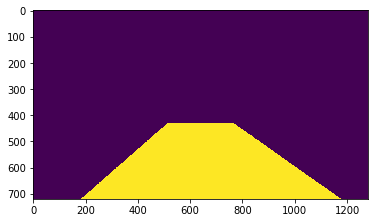

In [24]:
def get_thresholded_image(img):
    #img=mpimg.imread('./test_images/straight_lines1.jpg')
    
    undistorted = cal_undistort(img)
    img_size = (img.shape[1], img.shape[0])
    
    # Apply each of the thresholding functions
    # Choose a Sobel kernel size
    ksize = 3 # Choose a larger odd number to smooth gradient measurements
    gray = to_grayscale(img)
    gradx = abs_sobel_thresh(gray, orient='x', thresh_min=20, thresh_max=255)
    #grady = abs_sobel_thresh(gray, orient='y', thresh_min=5, thresh_max=95)
    rgb_binary = rgb_thresh(img)
    dir_binary = dir_threshold(gray, sobel_kernel=15, thresh=(0.7, 1.3))
    binary_hls = hls_select(img, s_thresh=(150, 255))
    
    channels = 255*np.dstack(( np.zeros_like(gradx), gradx, binary_hls)).astype('uint8')  
    
    combined = np.zeros_like(dir_binary)
    #combined[((gradx == 1) & (binary_hls == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    combined[((gradx == 1) & (dir_binary == 1)) | ((binary_hls == 1) & (rgb_binary == 1))] = 1
    #combined[(binary_hls == 1) & (grady == 1) | (gradx == 1)] = 1
    final_combined = 255*np.dstack((combined,combined,combined)).astype('uint8')
    
    image_ROI = mask_ROI(combined)
    #image_ROI = to_grayscale(image_ROI)
    
    
    warped, M = perspactive_transform(image_ROI)
    
    return warped,image_ROI,final_combined,gray,channels,binary_hls,dir_binary,rgb_binary,gradx

img=plt.imread('./test_images/test2.jpg')
warped,image_ROI,final_combined,gray,channels,binary_hls,dir_binary,rgb_binary,gradx = get_thresholded_image(img)
#plt.imshow(warped)

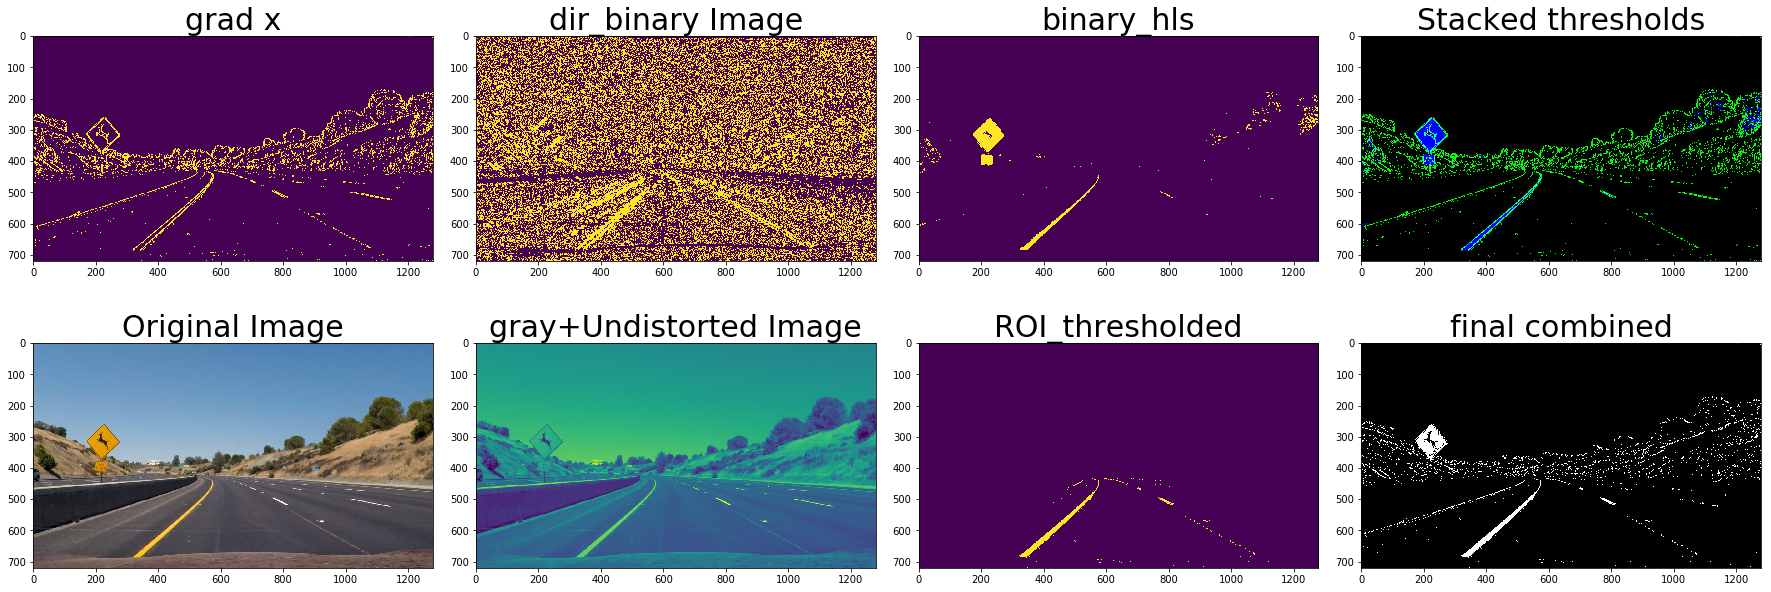

In [25]:
f, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2, 4, figsize=(24, 9))
f.tight_layout()
ax1.imshow(gradx)
ax1.set_title('grad x', fontsize=30)
ax2.imshow(dir_binary)
ax2.set_title('dir_binary Image', fontsize=30)
ax3.imshow(binary_hls)
ax3.set_title('binary_hls', fontsize=30)
ax4.imshow(channels)
ax4.set_title('Stacked thresholds', fontsize=30)
ax5.imshow(img)
ax5.set_title('Original Image', fontsize=30)
ax6.imshow(gray)
ax6.set_title('gray+Undistorted Image', fontsize=30)
ax7.imshow(image_ROI)
ax7.set_title('ROI_thresholded', fontsize=30)
ax8.imshow(final_combined)
ax8.set_title('final combined', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

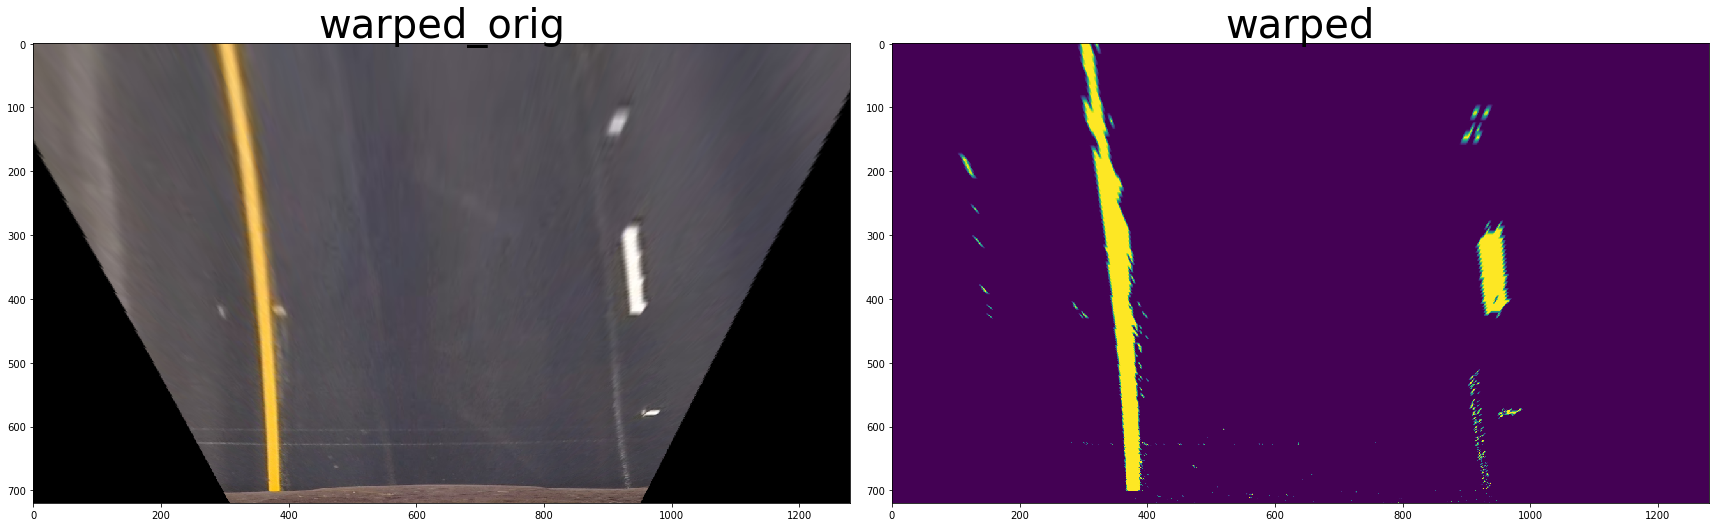

In [26]:
# apply the region of interest mask
img_size = (img.shape[1], img.shape[0])
height,width,_ = img.shape
mask = np.zeros_like(img)
#region_of_interest_vertices = np.array([[0,height-1], [width/2, int(0.5*height)], [width-1, height-1]], dtype=np.int32)
region_of_interest_vertices = np.array( [[(width/7, height),(0.4*width, 0.6*height),(0.6*width, 0.6*height),(0.92*width, height)]], dtype=np.int32 )
cv2.fillPoly(mask, [region_of_interest_vertices], (255,255,255))
orig_ROI = cv2.bitwise_and(img, mask)
warped_orig, M2 = perspactive_transform(orig_ROI)

# Plot the result
f, (ax1,ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(warped_orig)
ax1.set_title('warped_orig', fontsize=40)

ax2.imshow(warped)
ax2.set_title('warped', fontsize=40)

# Histogram
The peaks int the histogram tell us about the likely position of the lanes in the image.

368 932


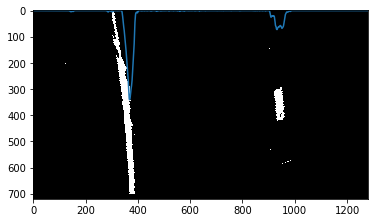

In [27]:
def histogram(warped):
    binary_warped = np.copy(warped)
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    #out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255   # if using l_channel to remove colors
    out_img = 255*np.dstack((binary_warped,binary_warped,binary_warped)).astype('uint8')  # if using CV2.___2gray
    plt.imshow(out_img)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    print(leftx_base, rightx_base)
    plt.plot(histogram)
    
    return leftx_base,rightx_base,midpoint,out_img

leftx_base,rightx_base,midpoint,out_img = histogram(warped)

368 932

leftx and lefty: [363 364 365 366 367 368 369 370 371 372] [640 640 640 640 640 640 640 640 640 640]

 [30986 30987 30988 30989 30990 30991 30992 30993 30994 30995] [363 364 365 366 367 368 369 370 371 372]

 [30986 30987 30988 30989 30990 30991 30992 30993 30994 30995] [640 640 640 640 640 640 640 640 640 640]
720 [ 301.49318716  301.68385677  301.8743004   302.06451806  302.25450973
  302.44427543  302.63381514  302.82312888  303.01221664  303.20107842]


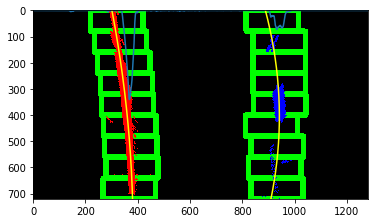

In [28]:
def find_lines(warped):
    binary_warped = np.copy(warped)
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_base,rightx_base,midpoint,out_img = histogram(warped)
    out_img__current = np.copy(out_img)
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 200
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 20) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 20) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        #print(len(good_left_inds),good_left_inds.shape,good_left_inds[:10])
        #print(len(good_right_inds),good_right_inds.shape,good_right_inds[:10],"\n")
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
    #print(len(left_lane_inds[0]),len(left_lane_inds[8]))  # 0,1,2..8 windows
    # Concatenate the arrays of indices (pixels inside windows)
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    #print(len(left_lane_inds))
    
    # Extract left and right line pixel positions within those windows
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    print("\nleftx and lefty:", leftx[:10], lefty[:10])  #random 10 pixels --testing purpose #comment out
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    print("\n", left_lane_inds[:10], nonzerox[left_lane_inds[:10]])  #X pos random 10 pixels --testing purpose #comment out
    print("\n", left_lane_inds[:10], nonzeroy[left_lane_inds[:10]])  #Y pos random 10 pixels --testing purpose #comment out
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    print(len(left_fitx),left_fitx[:10])   #random 10 pixels --testing purpose #comment out
    
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    
    return left_fit,right_fit,left_fitx,right_fitx,warped,left_lane_inds,right_lane_inds,margin
    
left_fit,right_fit,left_fitx,right_fitx,warped,left_lane_inds,right_lane_inds,margin = find_lines(warped)

In [29]:
def find_nxtLines(left_fit,right_fit,warped):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    binary_warped = np.copy(warped)
    
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 50
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  
    print(len(left_lane_inds),left_lane_inds[:10])   #random 10 pixels --testing purpose #comment out
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fit,right_fit,left_fitx,right_fitx,warped,left_lane_inds,right_lane_inds,margin

left_fit,right_fit,left_fitx,right_fitx,warped,left_lane_inds,right_lane_inds,margin = find_nxtLines(left_fit,right_fit,warped)

33164 [ True  True  True  True  True  True  True  True  True  True]


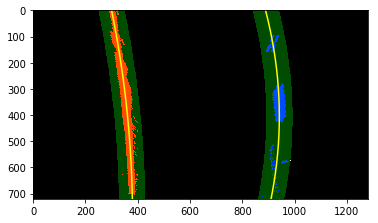

In [30]:
def draw_lane(left_fit,right_fit,warped,left_lane_inds,right_lane_inds,margin):
    # Create an image to draw on and an image to show the selection window
    #out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    binary_warped = np.copy(warped)
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )    
    out_img = 255*np.dstack((binary_warped,binary_warped,binary_warped)).astype('uint8')  # if using CV2.___2gray
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    plt.imshow(result)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)

draw_lane(left_fit,right_fit,warped,left_lane_inds,right_lane_inds,margin)

### Computing the radius of curvature and center offset.
The radius of curvature is computed according to the formula and method described in the classroom material. Since we perform the polynomial fit in pixels and whereas the curvature has to be calculated in real world meters, we have to use a pixel to meter transformation and recompute the fit again.
The mean of the lane pixels closest to the car gives us the center of the lane. The center of the image gives us the position of the car. The difference between the 2 is the offset from the center.

In [31]:
# Define y-value where we want radius of curvature 
# I'll choose the maximum y-value, corresponding to the bottom of the image
binary_warped = np.copy(warped)
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )    
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)   #in pixels

3892.25633841 1657.15049489


In [32]:
def radius_offset(left_fitx,right_fitx):
    #we actually need to repeat this calculation after converting our x and y values to real world space (in meters)
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    #print(left_curverad, 'm', right_curverad, 'm') # in meters
    
    average_curverad = (left_curverad + right_curverad)/2
    curvature_string = "Radius of curvature averaged of left and right curve: %.2f m" % average_curverad
    #print(curvature_string)
    
    # Offset
    #The offset of the lane center from the center of the image (converted from pixels to meters) is your distance from the center of the lane.
    lane_center = (left_fitx[719] + right_fitx[719])/2
    center_offset_pixels = abs(img_size[0]/2 - lane_center)
    center_offset_meters = xm_per_pix*center_offset_pixels
    #print("offset of cener camera from center of lane: ", center_offset_meters)
    
    return average_curverad, center_offset_meters

average_curverad, center_offset_meters = radius_offset(left_fitx,right_fitx)

1440 
 [[ 300.36464356    0.        ]
 [ 300.56702847    1.        ]
 [ 300.76915634    2.        ]
 [ 300.97102717    3.        ]
 [ 301.17264096    4.        ]
 [ 301.37399771    5.        ]
 [ 301.57509741    6.        ]
 [ 301.77594008    7.        ]
 [ 301.9765257     8.        ]
 [ 302.17685429    9.        ]]


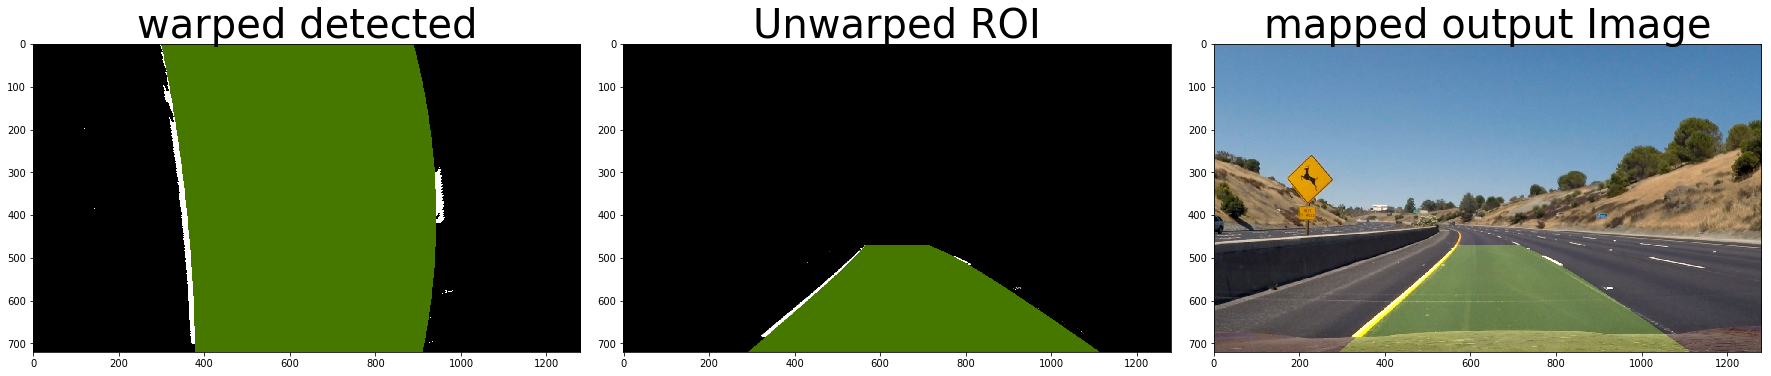

In [33]:
#out_img = 255*np.dstack((binary_warped,binary_warped,binary_warped)).astype('uint8')  # if using CV2.___2gray
#y_points = np.linspace(0, num_rows-1, num_rows)

left_line_window = np.array(np.transpose(np.vstack([left_fitx, ploty])))

right_line_window = np.array(np.flipud(np.transpose(np.vstack([right_fitx, ploty]))))

line_points = np.vstack((left_line_window, right_line_window))
print(len(line_points),'\n',line_points[:10])

cv2.fillPoly(out_img, np.int_([line_points]), [70,120, 0])
#plt.imshow(out_img)

image_unwrpd, M_inv = perspactive_transform(out_img, warp=False)

result = cv2.addWeighted(img, 1, image_unwrpd, 0.5, 0)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(out_img, cmap='gray')
ax1.set_title('warped detected', fontsize=40)
ax2.imshow(image_unwrpd, cmap='gray')
ax2.set_title('Unwarped ROI', fontsize=40)   #FYI only, not used anywhere in this secftion
ax3.imshow(result)
ax3.set_title('mapped output Image', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [36]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

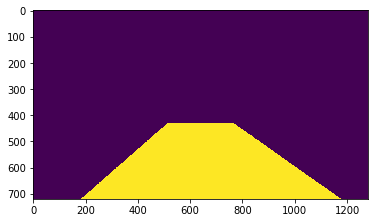

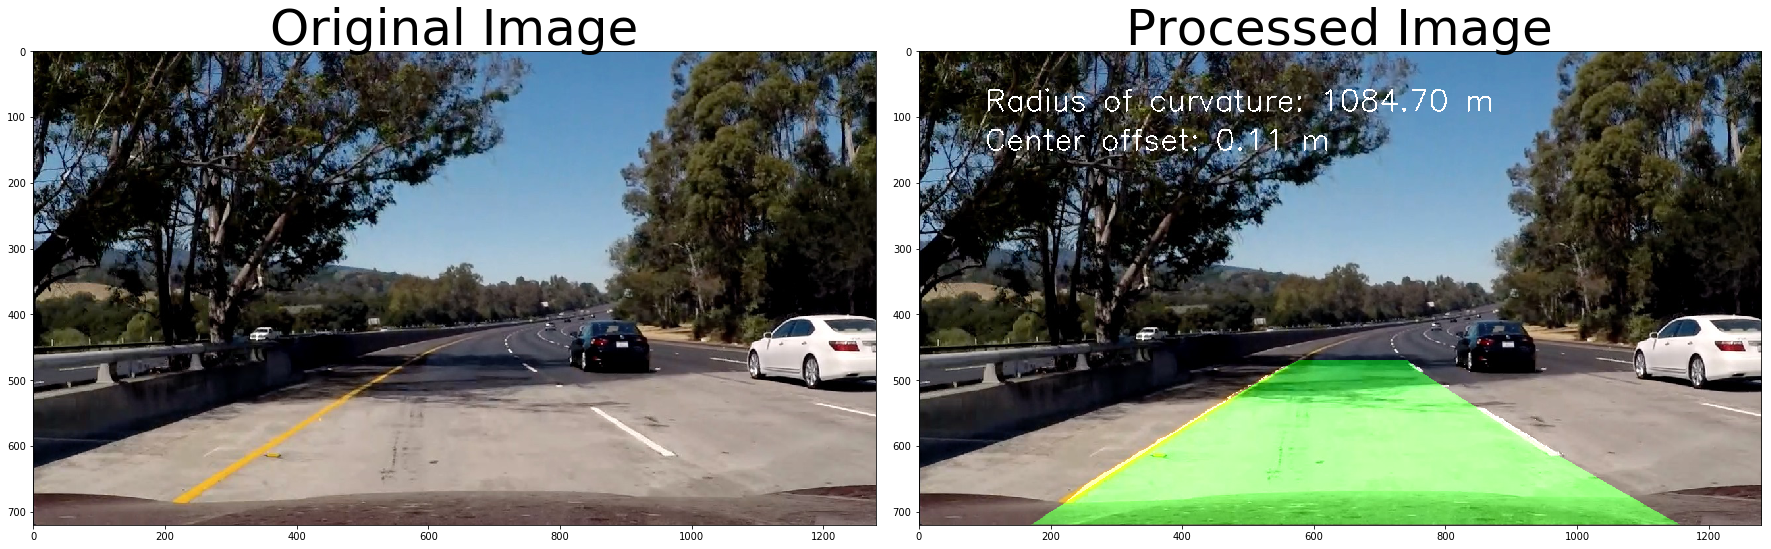

In [38]:
#img = mpimg.imread('test_images/test2.jpg')
img=plt.imread('./test_images/test5.jpg')

# Reinitialize some global variables.
polyfit_left = None
polyfit_right = None
past_good_right_lines = []
past_good_left_lines = []
running_mean_difference_between_lines = 0

# Apply pipeline
processed = pipeline_final(img)

# Plot the 2 images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(processed, cmap='gray')
ax2.set_title('Processed Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Process Video

In [24]:
from moviepy.editor import VideoFileClip
#from signal import signal, SIGPIPE, SIG_DFL
#signal(SIGPIPE,SIG_DFL) 

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [06:25<00:00,  3.38it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 19min 53s, sys: 34 s, total: 20min 27s
Wall time: 6min 26s


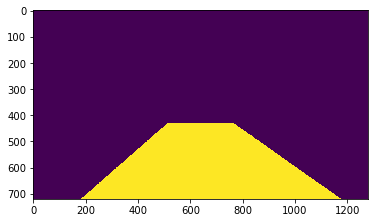

In [25]:
# Reinitialize some global variables.
polyfit_left = None
polyfit_right = None
past_good_right_lines = []
past_good_left_lines = []
running_mean_difference_between_lines = 0

video_in = VideoFileClip("project_video.mp4")
video_out = 'project_video_output.mp4'
out_clip = video_in.fl_image(pipeline_final) #NOTE: this function expects color images!!
%time out_clip.write_videofile(video_out, audio=False)